# Data preprocessing

In [4]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from torch import nn
from typing import List, Tuple, Dict
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.losses import SmapeLoss
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, r2_score, rmse
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
#from darts.models import *

from google.colab import files

## Load Electricity Data

In [5]:
df = pd.read_csv('data.csv', index_col=0)[['electricity']]
df.index = pd.date_range('1973-01-01', periods=602, freq='MS', name ='Month')
df.head()

,electricity
Month,
1973-01-01,159.913
1973-02-01,143.257
1973-03-01,147.847
1973-04-01,139.292
1973-05-01,147.088


In [6]:
start_date = '1973-01-01'
time_axis = pd.date_range(start_date, periods=602, freq="M")
series = TimeSeries.from_times_and_values(time_axis, df.values).astype(np.float32)

<Axes: xlabel='Month'>

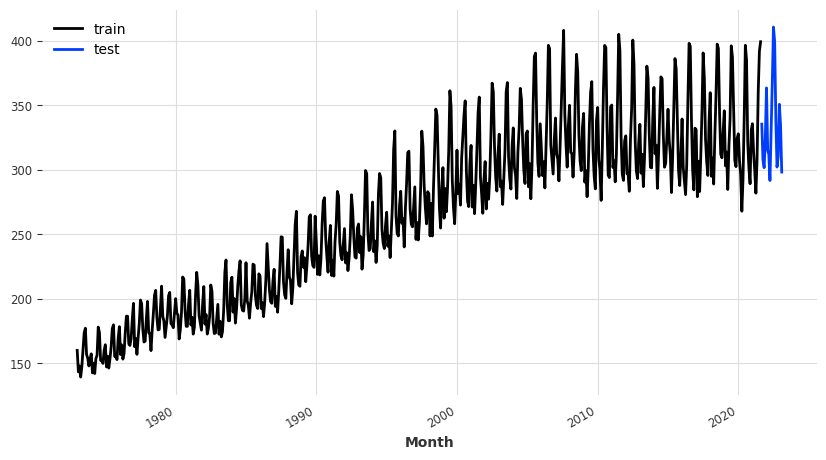

In [7]:
series = TimeSeries.from_dataframe(df).astype(np.float32)
train, test = series[:-18], series[-18:]
plt.figure(figsize=(10,5))
train.plot(label='train')
test.plot(label='test')

In [8]:
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
series_scaled = scaler.transform(series)

#Dictionary to hold results for revision
model_results=dict()
pred_results=dict()

## Load M3 Data

In [ ]:
#!pip install darts==0.18.0 &> /dev/null
!pip install xarray==0.18.2 &> /dev/null  # required to read pickle files
!pip install xlrd==2.0.1 &> /dev/null

In [ ]:
HORIZON=18
def load_m3() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    print("building M3 TimeSeries...")

    # Read DataFrame
    df_m3 = pd.read_excel("m3_dataset.xls", "M3Month")

    # Build TimeSeries
    m3_series = []
    for row in tqdm(df_m3.iterrows()):
        s = row[1]
        start_year = int(s["Starting Year"])
        start_month = int(s["Starting Month"])
        values_series = s[6:].dropna()
        if start_month == 0:
            continue

        start_date = datetime(year=start_year, month=start_month, day=1)
        time_axis = pd.date_range(start_date, periods=len(values_series), freq="M")
        series = TimeSeries.from_times_and_values(
            time_axis, values_series.values
        ).astype(np.float32)
        m3_series.append(series)

    print("\nThere are {} monthly series in the M3 dataset".format(len(m3_series)))

    # Split train/test
    print("splitting train/test...")
    m3_train = [s[:-HORIZON] for s in m3_series]
    m3_test = [s[-HORIZON:] for s in m3_series]

    # Scale so that the largest value is 1
    print("scaling...")
    scaler_m3 = Scaler(scaler=MaxAbsScaler())
    m3_train_scaled: List[TimeSeries] = scaler_m3.fit_transform(m3_train)
    m3_test_scaled: List[TimeSeries] = scaler_m3.transform(m3_test)

    # Added by ME
    scaler_m3 = Scaler(scaler=MaxAbsScaler())
    m3_series_scaled: List[TimeSeries] = scaler_m3.fit_transform(m3_series)


    print(
        "done. There are {} series, with average training length {}".format(
            len(m3_train_scaled), np.mean([len(s) for s in m3_train_scaled])
        )
    )
    return m3_train_scaled, m3_test_scaled, m3_series_scaled


def load_air() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    # load TimeSeries
    print("loading air TimeSeries...")
    with open("passengers.pkl", "rb") as f:
        all_air_series = pickle.load(f)

    # Split train/test
    print("splitting train/test...")
    air_train = [s[:-HORIZON] for s in all_air_series]
    air_test = [s[-HORIZON:] for s in all_air_series]

    # Scale so that the largest value is 1
    print("scaling series...")
    scaler_air = Scaler(scaler=MaxAbsScaler())
    air_train_scaled: List[TimeSeries] = scaler_air.fit_transform(air_train)
    air_test_scaled: List[TimeSeries] = scaler_air.transform(air_test)

    print(
        "done. There are {} series, with average training length {}".format(
            len(air_train_scaled), np.mean([len(s) for s in air_train_scaled])
        )
    )
    return air_train_scaled, air_test_scaled


def load_m4() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    # load TimeSeries - the splitting and scaling has already been done
    print("loading M4 TimeSeries...")
    with open("m4_monthly_scaled.pkl", "rb") as f:
        m4_series = pickle.load(f)

    # filter and keep only series that contain at least 48 training points
    m4_series = list(filter(lambda t: len(t[0]) >= 48, m4_series))

    m4_train_scaled, m4_test_scaled = zip(*m4_series)

    print(
        "done. There are {} series, with average training length {}".format(
            len(m4_train_scaled), np.mean([len(s) for s in m4_train_scaled])
        )
    )
    return m4_train_scaled, m4_test_scaled


In [ ]:
m3_train, m3_test, m3_series = load_m3() #already scaled

building M3 TimeSeries...


0it [00:00, ?it/s]


There are 1399 monthly series in the M3 dataset
splitting train/test...
scaling...
done. There are 1399 series, with average training length 100.30092923516797


In [ ]:
m4_train, m4_test = load_m4()

loading M4 TimeSeries...
done. There are 47992 series, with average training length 216.32901316886148


# Experimental parameters

In [9]:
IN_CHUNK = 30
OUT_CHUNK = 4
PRED_HOR = 18

N = series.n_timesteps
backtest_start = (N-PRED_HOR)/N

# Transfer NBEATS


In [10]:
# Slicing hyper-params:
IN_LEN = 30
OUT_LEN = 4

# Architecture hyper-params:
NUM_STACKS = 20
NUM_BLOCKS = 1
NUM_LAYERS = 2
LAYER_WIDTH = 136
COEFFS_DIM = 11

# Training settings:
LR = 1e-3
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 50
NUM_EPOCHS = 20

## M3 model

In [ ]:
from darts.models import NBEATSModel
# reproducibility
np.random.seed(42)
torch.manual_seed(42)

nbeats_model_m3 = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    batch_size=BATCH_SIZE,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    expansion_coefficient_dim=COEFFS_DIM,
    loss_fn=SmapeLoss(),
    optimizer_kwargs={"lr": LR},
    pl_trainer_kwargs={"accelerator": "gpu","devices": [0]},
)

# Train
nbeats_model_m3.fit(
    m3_series,
    num_loader_workers=4,
    epochs=NUM_EPOCHS,
    max_samples_per_ts=MAX_SAMPLES_PER_TS,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | SmapeLoss        | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 525 K 
---------------------------------------------------
523 K     Trainable params
1.9 K     Non-trainable params
525 K     Total params
2.102     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


NBEATSModel(generic_architecture=True, num_stacks=20, num_blocks=1, num_layers=2, layer_widths=136, expansion_coefficient_dim=11, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=4, batch_size=1024, loss_fn=SmapeLoss(), optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

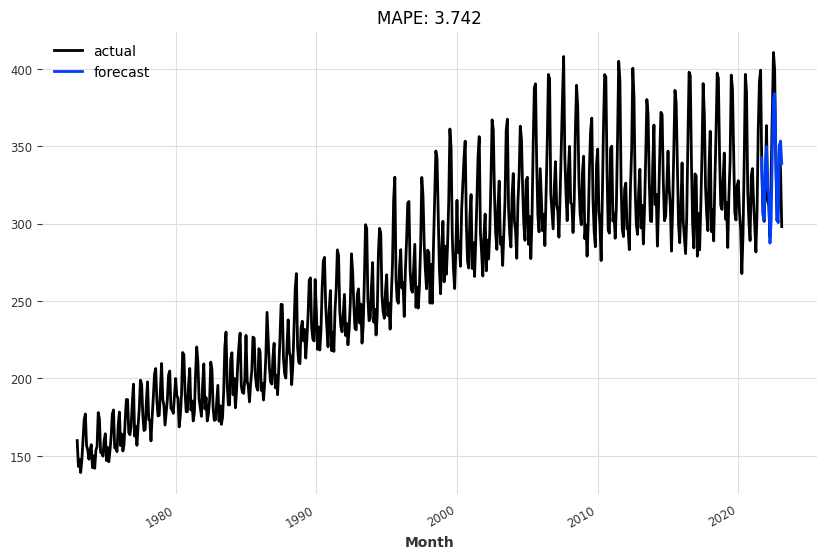

In [21]:
tic=time.time()
pred = nbeats_model_m3.predict(series=train_scaled, n=PRED_HOR)

# scale back:
pred = scaler.inverse_transform(pred)

toc=time.time()
model_results['NBEATS_M3'] = [mape(pred, test), r2_score(pred, test),
                              rmse(pred, test), toc-tic]
pred_results['M3'] = pred

plt.figure(figsize=(10, 6))
series.plot(label="actual")
pred.plot(label="forecast")
plt.title("MAPE: %.3f" % mape(pred, test))
plt.show()

In [ ]:
backtest = nbeats_model_m3.backtest(series=series_scaled,
                          start=backtest_start,
                          retrain=False,
                          forecast_horizon=OUT_CHUNK)

## M4 model

In [ ]:
from darts.models import NBEATSModel
# reproducibility
np.random.seed(42)
torch.manual_seed(42)

nbeats_model_m4 = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    batch_size=BATCH_SIZE,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    expansion_coefficient_dim=COEFFS_DIM,
    loss_fn=SmapeLoss(),
    optimizer_kwargs={"lr": LR},
    pl_trainer_kwargs={"accelerator": "gpu","devices": [0]},
)

# Train
nbeats_model_m4.fit(
    m4_series,
    num_loader_workers=4,
    epochs=NUM_EPOCHS,
    max_samples_per_ts=MAX_SAMPLES_PER_TS,
)

In [ ]:
tic=time.time()
pred = nbeats_model_m4.predict(series=train_scaled, n=PRED_HOR)

# scale back:
pred = scaler.inverse_transform(pred)

toc=time.time()
model_results['NBEATS_M4'] = [mape(pred, test), r2_score(pred, test),
                              rmse(pred, test), toc-tic]
pred_results['M4'] = pred

plt.figure(figsize=(10, 6))
series.plot(label="actual")
pred.plot(label="forecast")
plt.title("MAPE: %.3f" % mape(pred, test))
plt.show()

In [ ]:
backtest = nbeats_model_m4.backtest(series=series_scaled,
                          start=backtest_start,
                          retrain=False,
                          forecast_horizon=OUT_CHUNK)

# ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


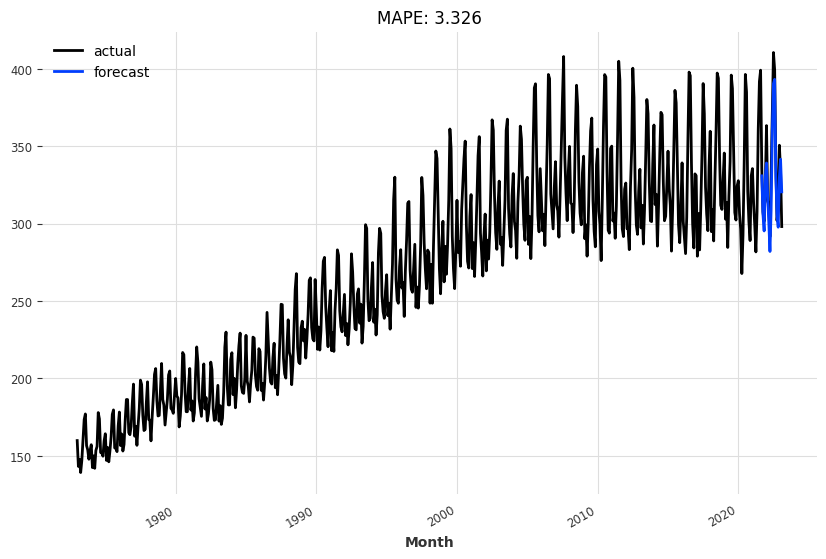

In [23]:
from darts.models import ARIMA
model = ARIMA()
tic=time.time()
model.fit(train_scaled)

pred = model.predict(n=PRED_HOR)

# scale back:
pred = scaler.inverse_transform(pred)


toc=time.time()
model_results['ARIMA'] = [mape(pred, test), r2_score(pred, test),
                              rmse(pred, test), toc-tic]
pred_results['ARIMA'] = pred

plt.figure(figsize=(10, 6))
series.plot(label="actual")
pred.plot(label="forecast")
plt.title("MAPE: %.3f" % mape(pred, test))
plt.savefig('arima_v2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
backtest = model.backtest(series=series_scaled, start=backtest_start, forecast_horizon=OUT_CHUNK)

# BlockRNN

In [25]:
from darts.models import BlockRNNModel
for key in ['RNN', 'GRU', 'LSTM']:
  tic=time.time()
  model = BlockRNNModel(input_chunk_length=IN_CHUNK,
                        output_chunk_length=OUT_CHUNK,
                        model=key,
                        random_state=42,
                        n_rnn_layers=2,
                        hidden_fc_sizes=[12,4])
  model.fit(train_scaled, epochs=20, verbose=True)

  pred = model.predict(series=train_scaled, n=PRED_HOR)

  # scale back:
  pred = scaler.inverse_transform(pred)
  toc=time.time()
  model_results[key] = [mape(pred, test), r2_score(pred, test),
                              rmse(pred, test), toc-tic]
  pred_results[key]=pred

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 384   
---------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 6.0 K 
4 | fc            | Sequential       | 384   
---------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 8.0 K 
4 | fc            | Sequential       | 384   
---------------------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.034     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [32]:
df_results = pd.DataFrame(model_results)
df_results.index=['MAPE', 'R2', 'RMSE', 'Time']
df_results.transpose()

,MAPE,R2,RMSE,Time
NBEATS_M4,3.742118,0.615445,16.780905,0.151145
NBEATS_M3,7.572600,-0.743703,29.191671,0.196498
ARIMA,3.326473,0.804763,13.099669,3.416353
RNN,8.396366,-354.775085,36.253910,9.510177
GRU,8.034973,-90.689369,33.665825,17.324589
LSTM,8.108890,-272.713135,34.101273,10.297812


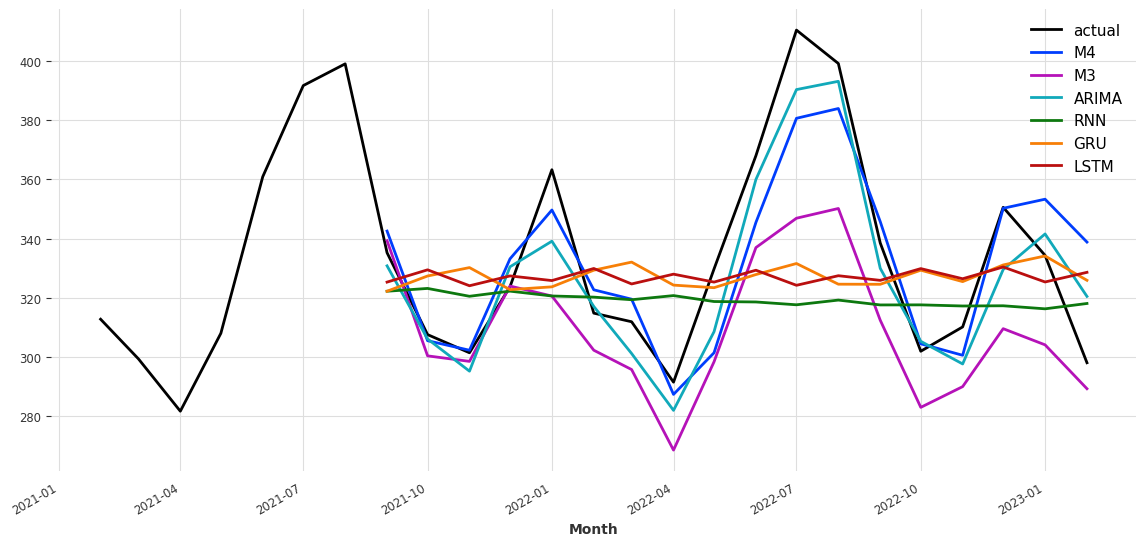

In [37]:
plt.figure(figsize=(14, 6))
series[-25:].plot(label="actual")
for key in pred_results.keys():
  pred_results[key].plot(label=key)
plt.legend(fontsize="11", loc ="upper right")
plt.show()